In [7]:
import os
import cv2
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
train_dir = "dataset/images/train"
valid_dir = "dataset/images/validation"


In [9]:
train_sub_folders = os.listdir(train_dir)

train_images = []
train_labels = []

# Iterate through each sub-folder (label) in the training directory
for label in train_sub_folders:
    # Construct the path to the current sub-folder
    path = os.path.join(train_dir, label)
    
    # List all images in the current sub-folder
    sub_folder_images = os.listdir(path)
    
    # Access each image
    for image_name in sub_folder_images:
        # Construct the path to the current image
        image_path = os.path.join(path, image_name)
        
        # Load the image using OpenCV
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        # Append the image to the list of images
        train_images.append(img)
        
        # Append the label corresponding to the current sub-folder to the list of labels
        train_labels.append(label)

# Do the same for the validation directory
valid_sub_folders = os.listdir(valid_dir)

valid_images = []
valid_labels = []

for label in valid_sub_folders:
    path = os.path.join(valid_dir, label)
    sub_folder_images = os.listdir(path)
    for image_name in sub_folder_images:
        image_path = os.path.join(path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        valid_images.append(img)
        valid_labels.append(label)

In [10]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)
print(len(train_images))
print(len(train_labels))
print(len(valid_images))
print(len(valid_labels))

8931
8931
2099
2099


In [11]:
X_train = train_images
y_train = train_labels

X_val = valid_images
y_val = valid_labels

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=48)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=8)

In [12]:
def preprocessing(img):
    img = img / 255.0
    img = cv2.resize(img, (48, 48))
    return img.reshape(-1, 48, 48, 1)  # Reshape to match input shape

In [13]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [14]:
X_train = X_train.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

In [15]:
X_train[0]

array([[[0.45882353],
        [0.45098039],
        [0.46666667],
        ...,
        [0.76862745],
        [0.6745098 ],
        [0.52156863]],

       [[0.48627451],
        [0.50980392],
        [0.44313725],
        ...,
        [0.73333333],
        [0.58823529],
        [0.50196078]],

       [[0.47843137],
        [0.54117647],
        [0.45098039],
        ...,
        [0.69411765],
        [0.5372549 ],
        [0.42352941]],

       ...,

       [[0.77254902],
        [0.69803922],
        [0.56078431],
        ...,
        [0.48627451],
        [0.31372549],
        [0.22745098]],

       [[0.82745098],
        [0.85098039],
        [0.87058824],
        ...,
        [0.57254902],
        [0.63137255],
        [0.45882353]],

       [[0.84313725],
        [0.81960784],
        [0.82745098],
        ...,
        [0.18039216],
        [0.35686275],
        [0.58039216]]])

In [16]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [17]:
num_classes = len(label_encoder.classes_)
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

In [172]:
checkpoint = ModelCheckpoint("model.keras", monitor="val_acc", verbose=1, save_best_only=True)

In [173]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

In [174]:
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

I dont want to interrupt epochs even if the next epoch accuracy is better and don't need to save best model cause of I will choose best of it between different forms (augmentation, dropout,  augmentation + dropout) We should be able to see the changes of accuracy and loss.
That's why I didn't implement callbacks_list.


## Sadece CNN

In [179]:
def build_model():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())

    # Fully connected layer 2
    model.add(Dense(512, activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.0008), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [180]:
model = build_model()

print(model.summary())

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,346,114 (16.58 MB)

 Trainable params: 4,342,146 (16.56 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


Decreasing batch_size, may help it to increase accuracy of the model. 

In [181]:
history = model.fit(
 X_train, y_train_categorical,
    batch_size=64,
    validation_data=(X_val, y_val_categorical),
    epochs=50)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 470ms/step - accuracy: 0.5340 - loss: 1.7602 - val_accuracy: 0.4366 - val_loss: 1.6052
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 507ms/step - accuracy: 0.6110 - loss: 1.4448 - val_accuracy: 0.4478 - val_loss: 1.4760
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 524ms/step - accuracy: 0.6613 - loss: 1.3037 - val_accuracy: 0.5634 - val_loss: 1.4644
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 534ms/step - accuracy: 0.7254 - loss: 1.1507 - val_accuracy: 0.5634 - val_loss: 1.7193
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 539ms/step - accuracy: 0.7516 - loss: 1.0380 - val_accuracy: 0.5761 - val_loss: 1.1762
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 545ms/step - accuracy: 0.7798 - loss: 0.9321 - val_accuracy: 0.5381 - val_loss: 1.1920
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 546ms/step - accuracy: 0.8245 - loss: 0.8070 - val_accuracy: 0.5672 - val_loss: 1.4382
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 51s 604ms/step - accuracy: 0.8545 - loss: 0.7162 - val_accu

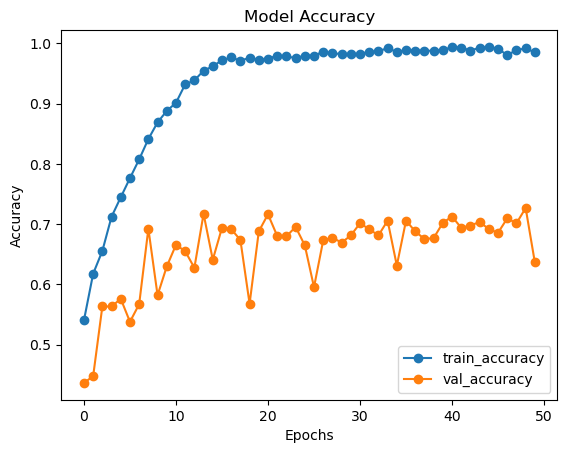

In [182]:
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


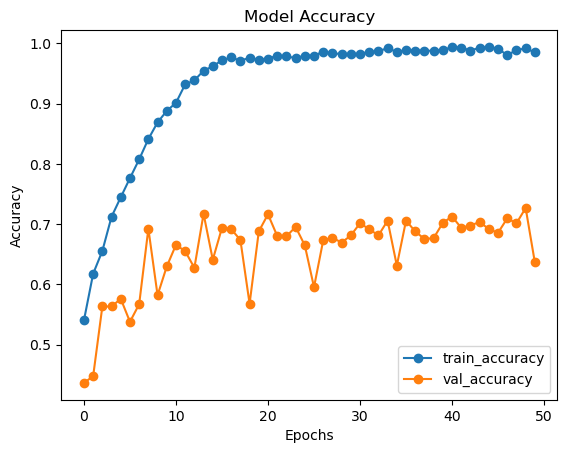

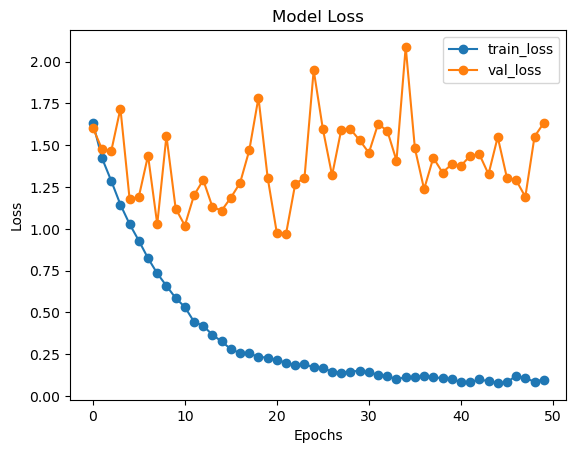

In [183]:
# Train accuracy vs Validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Train loss vs Validation loss
plt.plot(history.history['loss'], label='train_loss', marker='o')
plt.plot(history.history['val_loss'], label='val_loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

overfitting.

## Augmentation

In [190]:

def build_model_with_augmentation():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())

    # Fully connected layer 2
    model.add(Dense(512, activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Augmentation parameters
    datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rotation_range=10)
    datagen.fit(X_train)
    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.0008), loss='categorical_crossentropy', metrics=['accuracy'])

    return model, datagen

In [191]:
model, datagen = build_model_with_augmentation()

history = model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=64),
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    verbose=1
)


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 829ms/step - accuracy: 0.5487 - loss: 1.7629 - val_accuracy: 0.5634 - val_loss: 1.5247
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 964ms/step - accuracy: 0.5726 - loss: 1.4814 - val_accuracy: 0.4366 - val_loss: 1.6698
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 70s 828ms/step - accuracy: 0.6063 - loss: 1.3734 - val_accuracy: 0.5634 - val_loss: 1.4734
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 70s 828ms/step - accuracy: 0.6587 - loss: 1.2149 - val_accuracy: 0.5619 - val_loss: 1.2268
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 69s 825ms/step - accuracy: 0.6528 - loss: 1.1439 - val_accuracy: 0.5201 - val_loss: 1.1704
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 841ms/step - accuracy: 0.6869 - loss: 1.0307 - val_accuracy: 0.6381 - val_loss: 1.0386
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 70s 827ms/step - accuracy: 0.7117 - loss: 0.9504 - val_accuracy: 0.5000 - val_loss: 1.1933
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 70s 837ms/step - accuracy: 0.7034 - loss: 0.9028 - val_accu

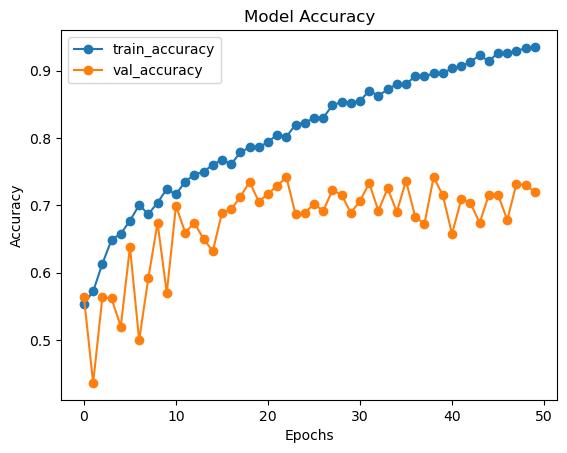

In [192]:
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


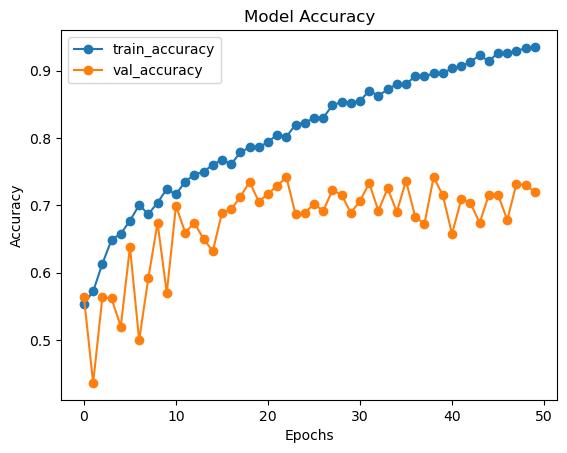

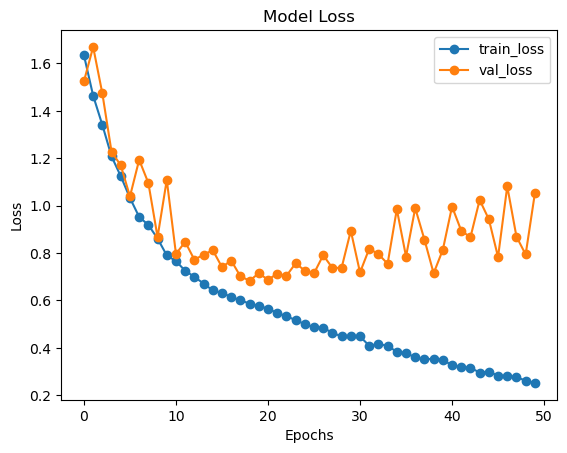

In [193]:
# Train accuracy vs Validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Train loss vs Validation loss
plt.plot(history.history['loss'], label='train_loss', marker='o')
plt.plot(history.history['val_loss'], label='val_loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

overfitting.

## Drop out

In [18]:

def build_model_with_dropout():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3)) 
    
    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))  

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3)) 

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3)) 

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) 

    # Fully connected layer 2
    model.add(Dense(512, activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) 

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.0008), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [19]:
model = build_model_with_dropout()
history = model.fit(
    X_train, y_train_categorical,
    batch_size=64,
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    verbose=1
)

Epoch 1/50


/Users/mustafa/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 476ms/step - accuracy: 0.5201 - loss: 1.8578 - val_accuracy: 0.5634 - val_loss: 2.1091
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 512ms/step - accuracy: 0.5468 - loss: 1.6620 - val_accuracy: 0.5634 - val_loss: 1.5202
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 534ms/step - accuracy: 0.5619 - loss: 1.5252 - val_accuracy: 0.4373 - val_loss: 1.5663
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 566ms/step - accuracy: 0.5970 - loss: 1.4263 - val_accuracy: 0.4381 - val_loss: 1.4589
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 574ms/step - accuracy: 0.6070 - loss: 1.3561 - val_accuracy: 0.5634 - val_loss: 1.4116
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 578ms/step - accuracy: 0.6358 - loss: 1.2627 - val_accuracy: 0.5612 - val_loss: 1.2764
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 579ms/step - accuracy: 0.6741 - loss: 1.1673 - val_accuracy: 0.5664 - val_loss: 1.3338
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 587ms/step - accuracy: 0.6838 - loss: 1.1111 - val_accuracy: 0.605

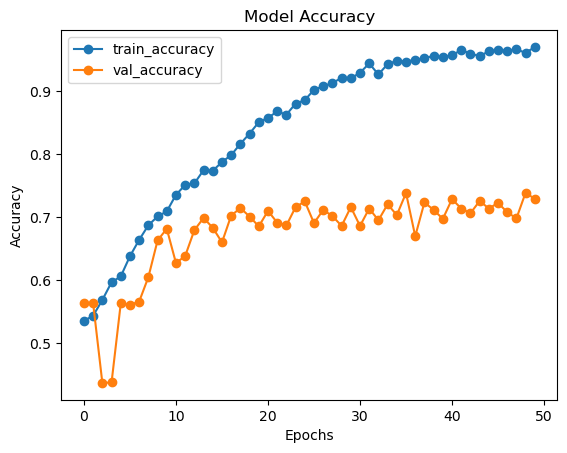

In [20]:
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


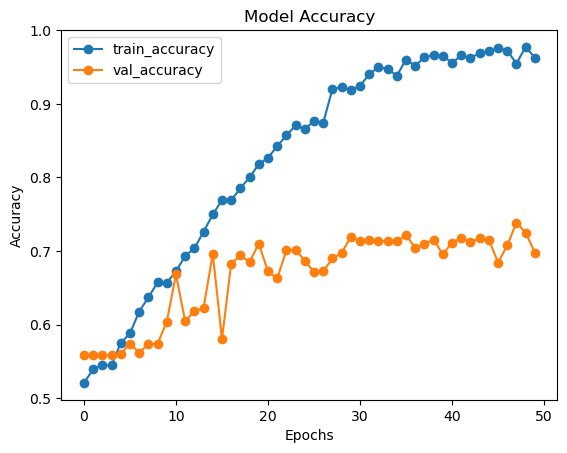

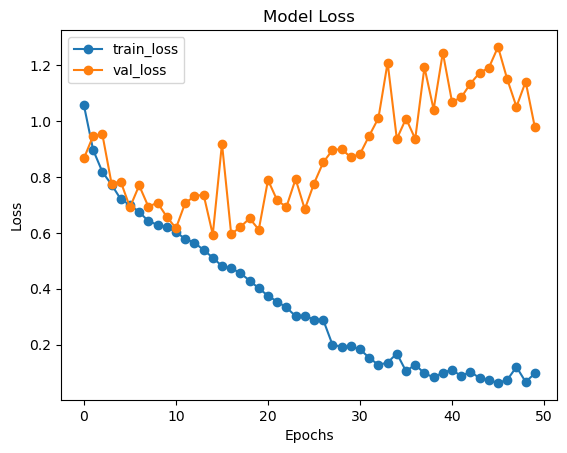

In [263]:
# Train accuracy vs Validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Train loss vs Validation loss
plt.plot(history.history['loss'], label='train_loss', marker='o')
plt.plot(history.history['val_loss'], label='val_loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

overfitting.

In [24]:

def build_model_with_dropout_and_augmentation():
    model = Sequential()
    # 1st Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3)) 

    # 2nd Layer
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3)) 

    # 3rd layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3)) 

    # 4th layer
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3)) 

    # Flatten Layer
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(256, activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) 

    # Fully connected layer 2
    model.add(Dense(512, activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3)) 

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rotation_range=10)
    datagen.fit(X_train)
    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.0008), loss='categorical_crossentropy', metrics=['accuracy'])

    return model,datagen

In [25]:
model, datagen = build_model_with_dropout_and_augmentation()

history = model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=64),
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    verbose=1
)


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 557ms/step - accuracy: 0.5160 - loss: 1.9084 - val_accuracy: 0.5634 - val_loss: 1.7433
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 572ms/step - accuracy: 0.5367 - loss: 1.6681 - val_accuracy: 0.5634 - val_loss: 1.4876
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 628ms/step - accuracy: 0.5439 - loss: 1.5552 - val_accuracy: 0.5634 - val_loss: 1.4620
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 51s 601ms/step - accuracy: 0.5390 - loss: 1.4879 - val_accuracy: 0.5657 - val_loss: 1.4030
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 644ms/step - accuracy: 0.5519 - loss: 1.4051 - val_accuracy: 0.5612 - val_loss: 1.3854
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 628ms/step - accuracy: 0.5830 - loss: 1.3137 - val_accuracy: 0.5590 - val_loss: 1.2994
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 50s 592ms/step - accuracy: 0.5889 - loss: 1.2532 - val_accuracy: 0.5642 - val_loss: 1.2404
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 50s 590ms/step - accuracy: 0.6089 - loss: 1.1773 - val_accu

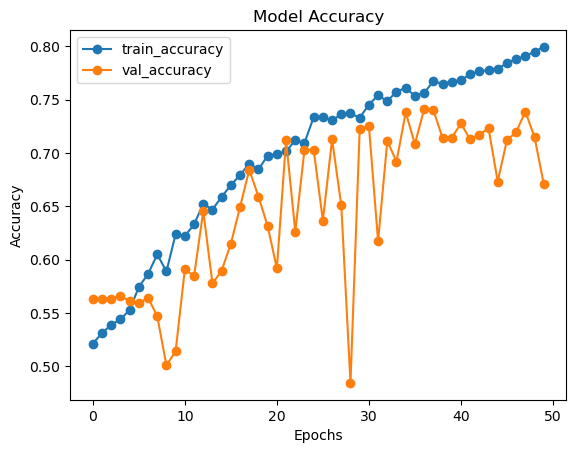

In [26]:
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


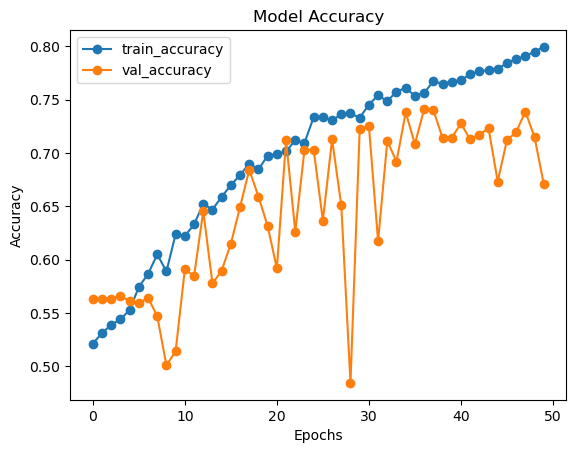

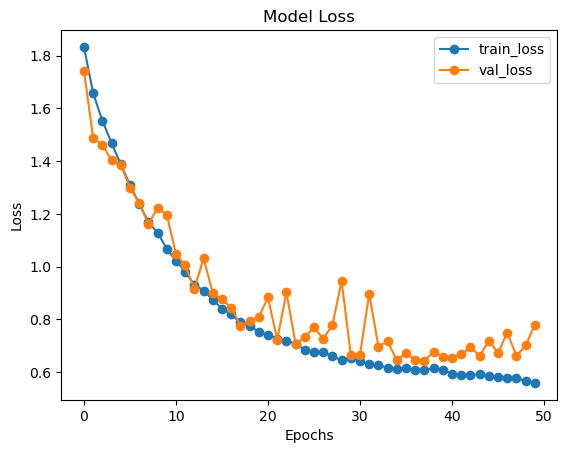

In [27]:
# Train accuracy vs Validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='val_accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Train loss vs Validation loss
plt.plot(history.history['loss'], label='train_loss', marker='o')
plt.plot(history.history['val_loss'], label='val_loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

overfitting.

In [28]:
model.save('face-expression-model.h5')